# (E11)11th_Project-Text_Summarization
**********************************************************************************
## 1. 데이터 수집하기
## 2. 데이터 전처리하기 (추상적 요약)
## 3. 모델 설계하기 & 훈련하기
## 4. 실제 결과와 요약문 비교하기 (추상적 요약)
## 5. Summa을 이용해서 추출적 요약해보기
************************************************************************************

## 1. 데이터 수집하기

In [1]:
import nltk
#nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

      뉴스기사 데이터는 https://github.com/sunnysai12345/News_Summary 에서 받아옵니다.
      밑의 코드로 바로 불러올 수 있습니다.

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

      불러온 데이터를 읽어와 확인해봅니다.

In [3]:
data.sample(10)

,headlines,text
80012,"I think after 126 films, I did an overdose of ...",Suniel Shetty has said that after doing 126 fi...
91913,Pune successfully defend 160 to register 3-run...,Rising Pune Supergiant ended Mumbai Indians' 6...
53328,"Non-striker Shaun hugs bro post ton, he asks h...",Australia batsman Shaun Marsh started celebrat...
18728,"Porsche 911 crashes, rolls more than 15 times ...",A Porsche 911 GT3 Cup crashed and rolled over ...
73505,Priyanka's Sikkimese production to premiere at...,Actress Priyanka Chopra's Sikkimese production...
60195,"Don't make parking lot, tourists can walk to T...",The Supreme Court on Monday denied permission ...
9520,Ranveer to move into Deepika's Mumbai house to...,Ranveer Singh will move into Deepika Padukone'...
93157,Sasikala's nephew booked for offering bribe fo...,The Delhi Police has booked AIADMK (Amma) chie...
30056,US to probe if the FBI spied on Trump campaign,The US Department of Justice (DOJ) agreed on M...
45066,My blog on Sridevi-Boney wasn't an investigati...,Bollywood trade analyst Komal Nahta has said h...


In [4]:
print(data.headlines[0])

upGrad learner switches to career in ML & Al with 90% salary hike


      데이터의 갯수를 확인해봅니다.

In [5]:
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98401


## 2. 데이터 전처리하기 (추상적 요약)

      중복 데이터를 제거해줍니다.

In [6]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [7]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


      NULL값을 가진 데이터가 있는지 확인해 줍니다. 이 데이터셋의 경우 없으므로 NULL을 제거하는 과정은 진행하지 않습니다.

In [8]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [9]:
#NULL값이 없으므로 진행하지 않아도 무방합니다.

#data.dropna(axis = 0, inplace = True)
#print('전체 샘플수 :',(len(data)))

      약어나 구어 표현을 전부 정규화 시켜줍니다.

In [6]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


      불용어를 제거해 줍니다.

In [7]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

      위에서 정규화 해주고 불용어를 제거하는 과정을 함수로 하나로 만들어 줍니다.

In [13]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

      위에서 작성한 함수가 제대로 작동하는지 데이터를 하나 불러와서 확인해봅니다.

In [14]:
temp_text = data.text[0]
temp_summary = data.headlines[0]

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers
upgrad learner switches to career in ml al with salary hike


      잘 작동하는 것을 확인했으면 이제 내용과 요약문을 전부 정규화하고 불용어를 제거해 줍니다.

In [15]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [16]:
clean_headlines = []

# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

      정규화하고 불용어를 제거한 문장을 'text'와 'headlines'칼럼에 넣어줍니다

In [17]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

      변경 과정에서 NULL값이 발생했는지 확인해 줍니다. 이 경우엔 발생하지 않았으므로 제거과정을 진행하지 않아도 됩니다.

In [18]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [19]:
#NULL값이 없으므로 진행하지 않아도 무방합니다.

#data.dropna(axis = 0, inplace = True)
#print('전체 샘플수 :',(len(data)))

      이제 문장의 단어 개수의 최대와 최소, 평균을 보고 얼마나 사용할 지 결정해줍니다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


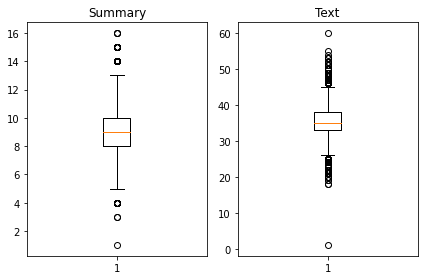

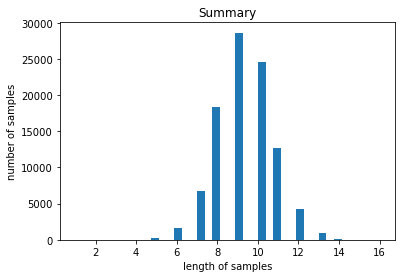

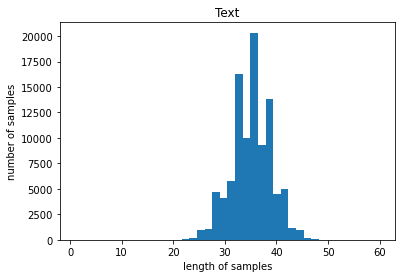

In [20]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [21]:
text_max_len = 38
summary_max_len = 10

      함수를 통해 위에서 결정한 최대 길이값이 전체 데이터를 얼마나 포함하고 있는지 확인합니다.

In [22]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

      'text'인 내용 컬럼에선 38로 결정할 경우 약 82%, 'headlines'에선 10으로 하니 약 82%로 최대한 동일하게 설정해줬습니다.

In [23]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.8163379422529483
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


      위에서 설정해준 최댓값을 벗어나는 데이터들은 전부 제거해줍니다. 제거한 후 총 데이터 갯수를 확인해봅니다.

In [24]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 65295


In [25]:
data.head(10)

,headlines,text
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...
16,karan johar tabu turn showstoppers on opening ...,filmmaker karan johar actress tabu turned show...
18,how long can tolerate congress leaders potshot...,days threatened step post congress mlas contin...
19,odisha cm patnaik controls mining mafia union ...,union minister dharmendra pradhan wednesday cl...
20,think the opposition even dreams about me pm modi,claiming dearth ideas among opposition parties...
22,killed injured in saudi arabia floods,least people killed others injured saudi arabi...


      이제 단어들을 토큰화 과정을 진행해줍니다. 먼저 앞과 뒤에 시작토큰과 종료토큰을 추가해줍니다.

In [27]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [28]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

      정확도를 위해 한번 섞어주는 과정을 진행해줍니다.

In [29]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[  272 44210 29660 ... 11386 16268  5788]


In [30]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

      학습 데이터에서 훈련셋과 테스트셋을 분리해줍니다. 이 과정에선 20%로 설정해줍니다.

In [34]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 13059


      훈련 데이터와 테스트 데이터가 잘 분리되었는지 확인해줍니다.

In [35]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 52236
훈련 레이블의 개수 : 52236
테스트 데이터의 개수 : 13059
테스트 레이블의 개수 : 13059


      토큰화를 진행해 줍니다. 먼저 나오는 횟수가 적고 희귀한 단어를 제거해줍니다. 6번 이하로 나오는 단어는 총 단어의 68.8%인데 사용 빈도는 4.5%이므로 제거해줍니다.

In [36]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [37]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 57284
등장 빈도가 6번 이하인 희귀 단어의 수: 39412
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17872
단어 집합에서 희귀 단어의 비율: 68.80106137839536
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.529283116607447


      위에서 6번 이하로 나오는 단어를 제외한 단어 집합의 크기가 17872이므로 18000을 단어집합의 크기로 제한해줍니다.

In [38]:
src_vocab = 18000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 18,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [39]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[4839, 405, 1129, 131, 66, 40, 6086, 45, 1504, 1924, 11530, 3707, 118, 222, 675, 45, 724, 486, 2570, 752, 71, 3630, 4839, 405, 73, 509, 752, 452, 17, 3855, 7, 1], [123, 753, 699, 604, 291, 363, 96, 699, 378, 459, 16626, 123, 3476, 724, 699, 336, 459, 1200, 1952, 663, 2303, 195, 363, 141, 104, 8401, 363, 144, 1066, 38, 988, 96, 496, 4161], [27, 108, 1360, 1149, 1480, 527, 6923, 1179, 14655, 288, 1241, 109, 5459, 16627, 1, 1424, 437, 2056, 527, 16627, 1, 19, 7, 2221, 470, 11110, 37, 47, 9, 1614, 909, 219, 8, 28, 30, 23]]


In [40]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

      디코더 부분도 위와 같은 과정을 진행해줍니다. 이번에는 5번 미만 등장 단어를 제거해줍니다.

In [41]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 25881
등장 빈도가 5번 이하인 희귀 단어의 수: 17494
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8387
단어 집합에서 희귀 단어의 비율: 67.59398786754763
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.5283823658301445


      단어 집합의 크기를 8000으로 제한해줍니다.

In [42]:
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 793, 6423, 303, 496, 31, 5, 7577, 6915, 58], [1, 524, 812, 29, 142, 340, 125, 17, 743, 7, 117], [1, 22, 41, 549, 3, 3753, 347, 5238, 1163, 4], [1, 64, 80, 936, 672, 118, 207, 4, 773, 277], [1, 1549, 1366, 292, 139, 732, 634, 352]]
target
decoder  [[793, 6423, 303, 496, 31, 5, 7577, 6915, 58, 2], [524, 812, 29, 142, 340, 125, 17, 743, 7, 117, 2], [22, 41, 549, 3, 3753, 347, 5238, 1163, 4, 2], [64, 80, 936, 672, 118, 207, 4, 773, 277, 2], [1549, 1366, 292, 139, 732, 634, 352, 2]]


      토큰화가 완료되고 다시 길이가 1인 데이터를 제거해줍니다. 이 경우 테스트데이터에서 하나 삭제되었습니다.

In [43]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 52236
훈련 레이블의 개수 : 52236
테스트 데이터의 개수 : 13058
테스트 레이블의 개수 : 13058


/home/aiffel-dj39/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [44]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

## 3. 모델 설계하기 & 훈련하기

      요약 모델을 설계하기 위해서 인코더와 디코더를 설계해줍니다.

In [45]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [46]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [47]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2304000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [48]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [49]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2304000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

      모델 설계를 끝냈으면 이제 학습을 시작합니다. 해당 과정은 val loss가 2번 이상 증가하면 멈춥니다. 각  Epoch당 약 1분씩 걸리고 대략 30번 전후로 학습을 종료합니다.

In [50]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
205/205 [==============================] - 57s 276ms/step - loss: 6.2362 - val_loss: 5.8492
Epoch 2/50
205/205 [==============================] - 56s 275ms/step - loss: 5.7349 - val_loss: 5.6089
Epoch 3/50
205/205 [==============================] - 56s 273ms/step - loss: 5.4453 - val_loss: 5.4163
Epoch 4/50
205/205 [==============================] - 56s 274ms/step - loss: 5.1717 - val_loss: 5.1524
Epoch 5/50
205/205 [==============================] - 56s 274ms/step - loss: 4.9434 - val_loss: 4.9614
Epoch 6/50
205/205 [==============================] - 56s 275ms/step - loss: 4.7472 - val_loss: 4.8473
Epoch 7/50
205/205 [==============================] - 56s 275ms/step - loss: 4.5776 - val_loss: 4.7321
Epoch 8/50
205/205 [==============================] - 57s 276ms/step - loss: 4.4275 - val_loss: 4.6220
Epoch 9/50
205/205 [==============================] - 56s 275ms/step - loss: 4.2862 - val_loss: 4.5723
Epoch 10/50
205/205 [==============================] - 56s 275ms/step - l

      모델이 학습을 진행하면서 loss와 val loss가 점점 감소하는 것을 확인 할 수 있습니다.

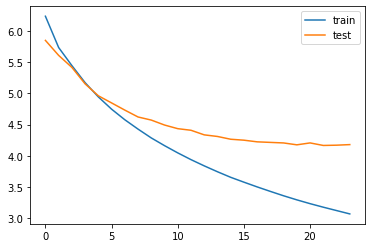

In [51]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 4. 실제 결과와 요약문 비교하기 (추상적 요약)

      모델을 이용하여 요약문을 생성하고 원래 요약문인 'headlines'와의 차이점을 비교해봅니다.

In [52]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [53]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [54]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [55]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [56]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [57]:
for i in range(0, 10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : elected prime minister pakistan managed complete full term office nation year history one pakistani government completed full term two prime ministers raza disqualified country witnessed three successful spent half time military rule 
실제 요약 : no pakistani pm has ever completed full term in office 
예측 요약 :  pm modi named world most powerful indian ambassador


원문 : video showing us president donald trump ignoring kid dressed dinosaur halloween event white house surfaced online trump greeting kids giving sweets apparently ignored child us president hosted nearly children adults first halloween celebration white house 
실제 요약 : trump kid in dinosaur costume during halloween event 
예측 요약 :  video trump son dog to trump


원문 : uttarakhand high court banned water sports state government frames policy regulate adding sports like river serious court observed sports pleasure cannot permitted end disaster also expressed concern environmental damages state maintaining sanctity river ganga 
실제

      전체적으로 정규화를 거친 headlines라서 원본을 예상하기가 어렵습니다. 전체적으로 성능이 별로 좋지 않은것같습니다....

## 5. Summa을 이용해서 추출적 요약해보기

      summa를 이용한 추출적 요약 모델을 이용하여 비교해봅니다.

In [2]:
import requests
from summa.summarizer import summarize

      data를 새로 불러와줍니다.

In [3]:
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

print("원문 :", data['text'])

원문 : 0        Saurav Kant, an alumnus of upGrad and IIIT-B's...
1        Kunal Shah's credit card bill payment platform...
2        New Zealand defeated India by 8 wickets in the...
3        With Aegon Life iTerm Insurance plan, customer...
4        Speaking about the sexual harassment allegatio...
                               ...                        
98396    A CRPF jawan was on Tuesday axed to death with...
98397    'Uff Yeh', the first song from the Sonakshi Si...
98398    According to reports, a new version of the 199...
98399    A new music video shows rapper Snoop Dogg aimi...
98400    Madhesi Morcha, an alliance of seven political...
Name: text, Length: 98401, dtype: object


      summa는 자동으로 토큰화 해주는 과정이 있기 때문에 따로 토큰화 과정을 취해줄 이유는 없는거같습니다. 다만 기호나 여러가지를 제거해가면서 확인해본 결과 영어 외 문자(숫자, 특수문자 등)은 제거할 경우 제대로 작동하지 않는것을 확인했습니다.

In [4]:
#데이터 전처리 함수
def preprocess_sentence2(sentence, remove_stopwords=True):
    #sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    #sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    #sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

      새로운 정규화 함수로 새로 데이터를 만들어줍니다.

In [8]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence2(s))

# 전처리 후 출력
clean_text[:5]

["Saurav Kant, alumnus upGrad IIIT-B's PG Program Machine learning Artificial Intelligence, Sr Systems Engineer Infosys almost years work experience. The program upGrad's 360-degree career support helped transition Data Scientist Tech Mahindra 90% salary hike. upGrad's Online Power Learning powered lakh+ careers.",
 "Kunal Shah's credit card bill payment platform, CRED, gave users chance win free food Swiggy one year. Pranav Kaushik, Delhi techie, bagged reward spending 2000 CRED coins. Users get one CRED coin per rupee bill paid, used avail rewards brands like Ixigo, BookMyShow, UberEats, Cult.Fit more.",
 "New Zealand defeated India wickets fourth ODI Hamilton Thursday win first match five-match ODI series. India lost international match Rohit Sharma's captaincy 12 consecutive victories dating back March 2018. The match witnessed India getting 92, seventh lowest total ODI cricket history.",
 'With Aegon Life iTerm Insurance plan, customers enjoy tax benefits premiums paid save Ã¢Â\x8

      요약문과 실제 요약을 비교해봅니다. summa의 경우 원문 자체도 문장이 별로 많지 않기때문에 최소 길이 2에 맞춰서 ratio를 0.5로, 단어갯수는 12개로 제한해주었습니다.

In [9]:
for i in range(0, 10):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("예측 요약 :", summarize(clean_text[i], ratio = 0.5, words = 12))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 : upGrad's Online Power Learning powered lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 : Users get one CRED coin per rupee bill paid, used a

      작성한 모델이 예측한 요약보다 좀 더 길고 조건이 까다로운 대신에 더 정확한 요약을 내놓는 거 같습니다.

*****************************************************************************************************************
# 총평 및 결론


      자연어 처리의 경우 전처리할 때 진행해야 할 과정도 너무 많고 모델 학습도 너무 복잡한 것 같다. 그리고 결과도 정확하다고는 할 수 없다고 생각한다. 작성한 모델의 경우 좀 더 짧고 주요한 내용을 담을 순 있었지만 문장이 아닌 단어와 단어로 내놓아 사람이 보기에는 바로 내용을 알긴 어려운것 같았다.
      추출적 방법을 사용한 경우엔 제공된 방법으로 진행해봤는데 추상적 요약하곤 다른 조건이 몇가지 있어서 진행하는데 어려움을 겪었다. 전처리를 어떻게 진행했느냐에 따라 전부 공백만 출력되는 경우도 있었고 문장이 원체 짧아서 그런지 Ratio값에 따라 또한 공백만 출력되는 문제가 있었다.